# Basic GNN Classifier on GREYC chemistry datasets
inspired and derived from https://pytorch-geometric.readthedocs.io/en/latest/notes/colabs.html

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch
from tqdm import tqdm

In [3]:
import torch
from greycdata.datasets import GreycDataset
#Choose Dataset between Acyclic, Alkane or MAO

dataset = GreycDataset(name='MAO',root='data/MAO')

In [4]:
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: MAO:
Number of graphs: 68
Number of features: 15
Number of classes: 2


In [5]:
data = dataset[0]  # Get a graph object.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')
print(data.x)
print(data.y)

Number of nodes: 11
Number of edges: 24
Average node degree: 2.18
Has isolated nodes: False
Has self-loops: False
Is undirected: True
tensor([[ 0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  2.0000, -0.4465, -1.2135,  0.0000],
        [ 1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  3.0000, -1.3282, -0.0000,  0.0000],
        [ 1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  2.0000, -0.4465,  1.2135,  0.0000],
        [ 1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  3.0000,  0.9801,  0.7500,  0.0000],
        [ 1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  2.0000,  2.2791,  1.5000,  0.0000],
        [ 1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.000

In [6]:
dataset = dataset.shuffle()
ratio_train = .9
size_train = int(len(dataset)*ratio_train)
size_test = len(dataset)-size_train
train_dataset = dataset[:size_train]
test_dataset = dataset[size_train:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 61
Number of test graphs: 7


In [7]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(dataset[0].y)
for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

tensor([1])
Step 1:
Number of graphs in the current batch: 8
DataBatch(edge_index=[2, 342], bond_type=[342], bond_stereo=[342], x=[160, 15], y=[8], batch=[160], ptr=[9])

Step 2:
Number of graphs in the current batch: 8
DataBatch(edge_index=[2, 304], bond_type=[304], bond_stereo=[304], x=[142, 15], y=[8], batch=[142], ptr=[9])

Step 3:
Number of graphs in the current batch: 8
DataBatch(edge_index=[2, 274], bond_type=[274], bond_stereo=[274], x=[129, 15], y=[8], batch=[129], ptr=[9])

Step 4:
Number of graphs in the current batch: 8
DataBatch(edge_index=[2, 302], bond_type=[302], bond_stereo=[302], x=[142, 15], y=[8], batch=[142], ptr=[9])

Step 5:
Number of graphs in the current batch: 8
DataBatch(edge_index=[2, 320], bond_type=[320], bond_stereo=[320], x=[149, 15], y=[8], batch=[149], ptr=[9])

Step 6:
Number of graphs in the current batch: 8
DataBatch(edge_index=[2, 350], bond_type=[350], bond_stereo=[350], x=[164, 15], y=[8], batch=[164], ptr=[9])

Step 7:
Number of graphs in the cu

In [8]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_add_pool
from mygnn.models import GCN_clf


class GCN(torch.nn.Module):
    def __init__(self, input_channels,hidden_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        
        x = global_add_pool(x, batch) 
        x = self.lin(x)
        return x

model = GCN_clf(input_channels=dataset.num_features,hidden_channels=64)
print(model)

GCN_clf(
  (conv): GCN(15, 64, num_layers=2)
)


In [9]:
model = GCN_clf(input_channels=dataset.num_features,hidden_channels=128)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    loss_epoch = 0.0
    for data in train_loader:  # Iterate in batches over the training dataset.
        out = model(data)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        
        loss_epoch += loss.item()
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
        loss_epoch += loss.item()
    return loss_epoch

def test(loader):
    model.eval()
    correct = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data)  
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.
    return correct / len(loader.dataset)  # Derive ratio of correct predictions.

losses=[]

for epoch in tqdm(range(1, 1000)):
    loss = train()
    losses.append(loss)

  0%|                                                                                                                                                                  | 0/999 [00:00<?, ?it/s]


NotImplementedError: Module [GCN_clf] is missing the required "forward" function

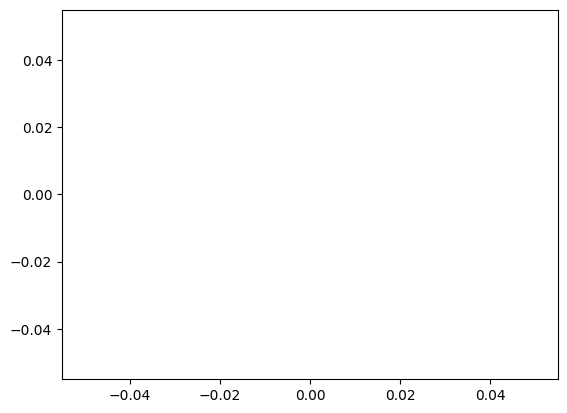

In [10]:
import matplotlib.pyplot as plt
plt.plot(losses)

In [ ]:
accuracy_train = test(train_loader)
print(f"Accuracy on train set :{accuracy_train:.2f}")
accuracy_test = test(test_loader)
print(f"Accuracy on train set :{accuracy_test:.2f}")